In [ ]:
import numpy as np 

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler # range 0-1
from sklearn.preprocessing import StandardScaler # mean=0, stdev=1 dividing a score’s deviation by the standard deviation
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Load the data

In [22]:
# # Download the dataset
# PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
# data = pd.read_csv(PATH_TO_DATA, header=None).add_prefix('S_')
# print(data['S_140'].value_counts())

# # last column is the target
# # 0 = anomaly, 1 = normal
# #switch values
# data.replace({'S_140':{0:1, 1:0}},inplace=True)

# data.insert(0, 'MACHINE_ID' , 77126575)
# data.insert(1, 'SENSOR_DATE',pd.date_range(start='2/1/2022', periods=len(data), freq='MIN'))
# data.rename({'S_140': 'TARGET'}, axis=1, inplace=True)

# print(data['TARGET'].value_counts())
# print(data.shape)
# print(data.head())

# data.to_csv('Data_orig/machine_anomaly.csv', index=False)

# data.iloc[287:297].drop(['TARGET'],axis=1).to_csv('Data_orig/machine_anomaly_test_1.csv', index=False) 

# test_target =data.iloc[287:297,-1]



# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None).add_prefix('S_')
print(data['S_140'].value_counts())

# last column is the target
# 0 = anomaly, 1 = normal
#switch values
data.replace({'S_140':{0:1, 1:0}},inplace=True)

data.insert(0, 'MACHINE_ID' , 77126575)
data.insert(1, 'SENSOR_DATE_ORIG',pd.date_range(start='1/1/2008', periods=len(data), freq='D')) 
data.rename({'S_140': 'TARGET'}, axis=1, inplace=True)

SENSOR_DATE = data.SENSOR_DATE_ORIG.dt.strftime('%Y-%m-%d')   #.astype(int)

 
data.insert(2, 'SENSOR_DATE', SENSOR_DATE) 
data.drop('SENSOR_DATE_ORIG', axis=1, inplace=True)

 

print(data['TARGET'].value_counts())
print(data.shape)
print(data.head())

data.to_csv('Data_orig/machine_anomaly.csv', index=False)

data.iloc[287:297].drop(['TARGET'],axis=1).to_csv('Data_orig/machine_anomaly_test_1.csv', index=False) 

test_target =data.iloc[287:297,-1]


data.SENSOR_DATE


1.0    2919
0.0    2079
Name: S_140, dtype: int64
0.0    2919
1.0    2079
Name: TARGET, dtype: int64
(4998, 143)
   MACHINE_ID SENSOR_DATE       S_0       S_1       S_2       S_3       S_4  \
0    77126575  2008-01-01 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041   
1    77126575  2008-01-02 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377   
2    77126575  2008-01-03 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449   
3    77126575  2008-01-04  0.490473 -1.914407 -3.616364 -4.318823 -4.268016   
4    77126575  2008-01-05  0.800232 -0.874252 -2.384761 -3.973292 -4.338224   

        S_5       S_6       S_7  ...     S_131     S_132     S_133     S_134  \
0 -3.474986 -2.181408 -1.818286  ...  0.792168  0.933541  0.796958  0.578621   
1 -3.234368 -1.566126 -0.992258  ...  0.538356  0.656881  0.787490  0.724046   
2 -3.151462 -1.742940 -1.490659  ...  0.886073  0.531452  0.311377 -0.021919   
3 -3.881110 -2.993280 -1.671131  ...  0.350816  0.499111  0.600345  0.842069   
4 -3.802422 

0       2008-01-01
1       2008-01-02
2       2008-01-03
3       2008-01-04
4       2008-01-05
           ...    
4993    2021-09-02
4994    2021-09-03
4995    2021-09-04
4996    2021-09-05
4997    2021-09-06
Name: SENSOR_DATE, Length: 4998, dtype: object

In [23]:
machine = pd.read_csv('Data_orig/machine_anomaly.csv')
machine['TARGET']
print(machine['TARGET'].value_counts()) 

0.0    2919
1.0    2079
Name: TARGET, dtype: int64


## Split the data for training and testing

In [24]:
target = machine['TARGET']

features = machine.drop(['MACHINE_ID', 'SENSOR_DATE', 'TARGET'], axis=1)
 
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target)

 

In [25]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]

 

## Scale the data using MinMaxScaler

In [26]:
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_data.copy())
x_test_scaled = scaler.transform(x_test.copy())

pickle.dump(scaler, open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_scaler.pickle', 'wb'))

## Build an AutoEncoder model

In [27]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [28]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 41ms/step - loss: 0.1423 - mse: 1.2478 - val_loss: 0.1952 - val_mse: 2.4818
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1409 - mse: 1.2375 - val_loss: 0.1918 - val_mse: 2.4533
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1385 - mse: 1.2178 - val_loss: 0.1858 - val_mse: 2.3981
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1347 - mse: 1.1851 - val_loss: 0.1797 - val_mse: 2.3292
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1316 - mse: 1.1557 - val_loss: 0.1762 - val_mse: 2.2770
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.1286 - mse: 1.1311 - val_loss: 0.1754 - val_mse: 2.2581
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1264 - mse: 1.1184 - val_loss: 0.1753 - val_mse: 2.2588
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.1245 - mse: 1.1103 - val

## Plot history

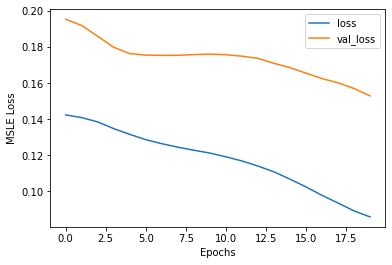

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Find threshold

In [30]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  # choose a threshold value that is one standard deviations above the mean.  
 
  threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  #preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

In [31]:
predictions = model.predict(x_test_scaled[0:1])
#print(predictions)

#type(predictions), type(test_data)
#x_test_scaled[0:1]
#print(predictions[0])

 

In [32]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

Threshold method one: 0.13918493504076626
Threshold method two: 0.19519625822615172


In [33]:
pickle.dump(threshold, open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_threshold.pickle', 'wb'))

gene = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_threshold.pickle', 'rb'))    
gene

0.13918493504076626

In [34]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)
 

0.939

In [35]:
preds[0]

# preds[0:11], y_test.iloc[0:11], x_test_scaled[0]

1.0

# Write Out Tensorflow (Keras) Model

In [36]:
from tensorflow import keras

gene = x_test_scaled[0:1]

modelName = "FAILURE_Tensorflow_Autoencoder"
dir =  "/sasinside/userdata/gegrab/resources/hmeq/"

model.save(dir + modelName)
#tf.keras.models.save_model(dir + modelName)

sess = keras.models.load_model(dir+ modelName)
#sess = tf.keras.models.load_model(dir+modelName)




P_FAILURE = sess.predict(gene)

P_FAILURE



array([[3.76880169e-04, 1.67788863e-02, 9.36573505e-01, 7.53196657e-01,
        9.09284711e-01, 5.70903838e-01, 9.15075898e-01, 9.99612451e-01,
        9.98230815e-01, 9.94687557e-01, 9.98071313e-01, 9.99876559e-01,
        9.99770522e-01, 9.99968946e-01, 9.99971390e-01, 9.99962568e-01,
        9.99679923e-01, 9.98948991e-01, 9.99974012e-01, 9.99930859e-01,
        9.99976754e-01, 9.99745607e-01, 9.98048306e-01, 9.99925256e-01,
        9.99977112e-01, 9.99982834e-01, 9.99924541e-01, 9.99934316e-01,
        9.99971032e-01, 9.99856353e-01, 9.99933362e-01, 9.99993563e-01,
        9.99998450e-01, 1.00000000e+00, 9.99943733e-01, 9.99995470e-01,
        9.99995232e-01, 9.98732090e-01, 9.99994516e-01, 9.99994040e-01,
        9.99998450e-01, 9.99998331e-01, 1.00000000e+00, 1.00000000e+00,
        9.99880791e-01, 9.99980450e-01, 9.99991715e-01, 1.00000000e+00,
        9.99997556e-01, 9.99999404e-01, 9.99997020e-01, 9.99988317e-01,
        9.99980211e-01, 9.99676704e-01, 9.99995589e-01, 9.999930

In [37]:
input_params = ''
for col in machine.columns:
    input_params += col
    if col != machine.columns[-1]:
        input_params += ', '

input_cols = ''
for col in machine.columns:
    input_cols += "\"" + col + "\""
    if col != machine.columns[-1]:
        input_cols += ', '


print(input_cols)
print("")
print(input_params)

"MACHINE_ID", "SENSOR_DATE", "S_0", "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10", "S_11", "S_12", "S_13", "S_14", "S_15", "S_16", "S_17", "S_18", "S_19", "S_20", "S_21", "S_22", "S_23", "S_24", "S_25", "S_26", "S_27", "S_28", "S_29", "S_30", "S_31", "S_32", "S_33", "S_34", "S_35", "S_36", "S_37", "S_38", "S_39", "S_40", "S_41", "S_42", "S_43", "S_44", "S_45", "S_46", "S_47", "S_48", "S_49", "S_50", "S_51", "S_52", "S_53", "S_54", "S_55", "S_56", "S_57", "S_58", "S_59", "S_60", "S_61", "S_62", "S_63", "S_64", "S_65", "S_66", "S_67", "S_68", "S_69", "S_70", "S_71", "S_72", "S_73", "S_74", "S_75", "S_76", "S_77", "S_78", "S_79", "S_80", "S_81", "S_82", "S_83", "S_84", "S_85", "S_86", "S_87", "S_88", "S_89", "S_90", "S_91", "S_92", "S_93", "S_94", "S_95", "S_96", "S_97", "S_98", "S_99", "S_100", "S_101", "S_102", "S_103", "S_104", "S_105", "S_106", "S_107", "S_108", "S_109", "S_110", "S_111", "S_112", "S_113", "S_114", "S_115", "S_116", "S_117", "S_118", "S_119", "

In [38]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [40]:
def scoreTF(MACHINE_ID, SENSOR_DATE, S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36, S_37, S_38, S_39, S_40, S_41, S_42, S_43, S_44, S_45, S_46, S_47, S_48, S_49, S_50, S_51, S_52, S_53, S_54, S_55, S_56, S_57, S_58, S_59, S_60, S_61, S_62, S_63, S_64, S_65, S_66, S_67, S_68, S_69, S_70, S_71, S_72, S_73, S_74, S_75, S_76, S_77, S_78, S_79, S_80, S_81, S_82, S_83, S_84, S_85, S_86, S_87, S_88, S_89, S_90, S_91, S_92, S_93, S_94, S_95, S_96, S_97, S_98, S_99, S_100, S_101, S_102, S_103, S_104, S_105, S_106, S_107, S_108, S_109, S_110, S_111, S_112, S_113, S_114, S_115, S_116, S_117, S_118, S_119, S_120, S_121, S_122, S_123, S_124, S_125, S_126, S_127, S_128, S_129, S_130, S_131, S_132, S_133, S_134, S_135, S_136, S_137, S_138, S_139 ):
    "Output: ANOMALY_FLAG, errors, threshold,  max_anomaly_sensor"
    
    import pickle
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    
    inputArray = pd.DataFrame([[MACHINE_ID, SENSOR_DATE, S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36, S_37, S_38, S_39, S_40, S_41, S_42, S_43, S_44, S_45, S_46, S_47, S_48, S_49, S_50, S_51, S_52, S_53, S_54, S_55, S_56, S_57, S_58, S_59, S_60, S_61, S_62, S_63, S_64, S_65, S_66, S_67, S_68, S_69, S_70, S_71, S_72, S_73, S_74, S_75, S_76, S_77, S_78, S_79, S_80, S_81, S_82, S_83, S_84, S_85, S_86, S_87, S_88, S_89, S_90, S_91, S_92, S_93, S_94, S_95, S_96, S_97, S_98, S_99, S_100, S_101, S_102, S_103, S_104, S_105, S_106, S_107, S_108, S_109, S_110, S_111, S_112, S_113, S_114, S_115, S_116, S_117, S_118, S_119, S_120, S_121, S_122, S_123, S_124, S_125, S_126, S_127, S_128, S_129, S_130, S_131, S_132, S_133, S_134, S_135, S_136, S_137, S_138, S_139]],
                              columns = ["MACHINE_ID", "SENSOR_DATE", "S_0", "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10", "S_11", "S_12", "S_13", "S_14", "S_15", "S_16", "S_17", "S_18", "S_19", "S_20", "S_21", "S_22", "S_23", "S_24", "S_25", "S_26", "S_27", "S_28", "S_29", "S_30", "S_31", "S_32", "S_33", "S_34", "S_35", "S_36", "S_37", "S_38", "S_39", "S_40", "S_41", "S_42", "S_43", "S_44", "S_45", "S_46", "S_47", "S_48", "S_49", "S_50", "S_51", "S_52", "S_53", "S_54", "S_55", "S_56", "S_57", "S_58", "S_59", "S_60", "S_61", "S_62", "S_63", "S_64", "S_65", "S_66", "S_67", "S_68", "S_69", "S_70", "S_71", "S_72", "S_73", "S_74", "S_75", "S_76", "S_77", "S_78", "S_79", "S_80", "S_81", "S_82", "S_83", "S_84", "S_85", "S_86", "S_87", "S_88", "S_89", "S_90", "S_91", "S_92", "S_93", "S_94", "S_95", "S_96", "S_97", "S_98", "S_99", "S_100", "S_101", "S_102", "S_103", "S_104", "S_105", "S_106", "S_107", "S_108", "S_109", "S_110", "S_111", "S_112", "S_113", "S_114", "S_115", "S_116", "S_117", "S_118", "S_119", "S_120", "S_121", "S_122", "S_123", "S_124", "S_125", "S_126", "S_127", "S_128", "S_129", "S_130", "S_131", "S_132", "S_133", "S_134", "S_135", "S_136", "S_137", "S_138", "S_139"]
                               )

    
    inputArray.drop(['MACHINE_ID', 'SENSOR_DATE'],axis=1, inplace=True)
    
    #print(type(gene))
    scaler = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_scaler.pickle', 'rb'))
    
    test_data = scaler.transform(inputArray)
     
    tf.convert_to_tensor(test_data)
    
     
    
    #sess = tf.keras.models.load_model("/sasinside/userdata/gegrab/resources/hmeq/FAILURE_Tensorflow_Autoencoder")
    sess = keras.models.load_model("/sasinside/userdata/gegrab/resources/hmeq/FAILURE_Tensorflow_Autoencoder")
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_threshold.pickle', 'rb')) 
    predictions = sess.predict(test_data)
    errors = tf.keras.losses.msle(predictions, test_data)
    
    features= np.subtract(predictions, test_data)**2
    sensor_flag= 'S_' + str(int(np.where(features ==np.amax(features))[1])) 
     
   

    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    
 
    
    ANOMALY_FLAG =float(preds)
    errors=float(errors)
    threshold=float(threshold)
    
    if ANOMALY_FLAG == 1:
        max_anomaly_sensor = sensor_flag
    else:
        max_anomaly_sensor= ' '

     
    
    
    return (ANOMALY_FLAG, errors,threshold,  max_anomaly_sensor)
    
 

In [41]:
import pandas as pd
X_test2 = pd.read_csv('Data_orig/machine_anomaly_test_1.csv')

for i in range(10):
    print(scoreTF(**X_test2.iloc[i]))
 

(0.0, 0.1015612329558971, 0.13918493504076626, ' ')
(0.0, 0.07110579959619269, 0.13918493504076626, ' ')
(1.0, 0.15922357554450436, 0.13918493504076626, 'S_132')
(0.0, 0.08813256183414701, 0.13918493504076626, ' ')
(0.0, 0.07477334842534157, 0.13918493504076626, ' ')
(1.0, 0.25150121377609685, 0.13918493504076626, 'S_132')
(1.0, 0.25365061733337263, 0.13918493504076626, 'S_132')
(1.0, 0.2435144101731589, 0.13918493504076626, 'S_136')
(1.0, 0.2536326652770436, 0.13918493504076626, 'S_132')
(1.0, 0.28506472120374327, 0.13918493504076626, 'S_138')


In [102]:
#X_test2.dtypes

In [42]:
score_code = """
def scoreTF(MACHINE_ID, SENSOR_DATE, S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36, S_37, S_38, S_39, S_40, S_41, S_42, S_43, S_44, S_45, S_46, S_47, S_48, S_49, S_50, S_51, S_52, S_53, S_54, S_55, S_56, S_57, S_58, S_59, S_60, S_61, S_62, S_63, S_64, S_65, S_66, S_67, S_68, S_69, S_70, S_71, S_72, S_73, S_74, S_75, S_76, S_77, S_78, S_79, S_80, S_81, S_82, S_83, S_84, S_85, S_86, S_87, S_88, S_89, S_90, S_91, S_92, S_93, S_94, S_95, S_96, S_97, S_98, S_99, S_100, S_101, S_102, S_103, S_104, S_105, S_106, S_107, S_108, S_109, S_110, S_111, S_112, S_113, S_114, S_115, S_116, S_117, S_118, S_119, S_120, S_121, S_122, S_123, S_124, S_125, S_126, S_127, S_128, S_129, S_130, S_131, S_132, S_133, S_134, S_135, S_136, S_137, S_138, S_139 ):
    "Output: ANOMALY_FLAG, errors, threshold,  max_anomaly_sensor"
    
    import pickle
    import numpy as np
    import pandas as pd
    import tensorflow as tf
    from tensorflow import keras
    
    inputArray = pd.DataFrame([[MACHINE_ID, SENSOR_DATE, S_0, S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36, S_37, S_38, S_39, S_40, S_41, S_42, S_43, S_44, S_45, S_46, S_47, S_48, S_49, S_50, S_51, S_52, S_53, S_54, S_55, S_56, S_57, S_58, S_59, S_60, S_61, S_62, S_63, S_64, S_65, S_66, S_67, S_68, S_69, S_70, S_71, S_72, S_73, S_74, S_75, S_76, S_77, S_78, S_79, S_80, S_81, S_82, S_83, S_84, S_85, S_86, S_87, S_88, S_89, S_90, S_91, S_92, S_93, S_94, S_95, S_96, S_97, S_98, S_99, S_100, S_101, S_102, S_103, S_104, S_105, S_106, S_107, S_108, S_109, S_110, S_111, S_112, S_113, S_114, S_115, S_116, S_117, S_118, S_119, S_120, S_121, S_122, S_123, S_124, S_125, S_126, S_127, S_128, S_129, S_130, S_131, S_132, S_133, S_134, S_135, S_136, S_137, S_138, S_139]],
                              columns = ["MACHINE_ID", "SENSOR_DATE", "S_0", "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10", "S_11", "S_12", "S_13", "S_14", "S_15", "S_16", "S_17", "S_18", "S_19", "S_20", "S_21", "S_22", "S_23", "S_24", "S_25", "S_26", "S_27", "S_28", "S_29", "S_30", "S_31", "S_32", "S_33", "S_34", "S_35", "S_36", "S_37", "S_38", "S_39", "S_40", "S_41", "S_42", "S_43", "S_44", "S_45", "S_46", "S_47", "S_48", "S_49", "S_50", "S_51", "S_52", "S_53", "S_54", "S_55", "S_56", "S_57", "S_58", "S_59", "S_60", "S_61", "S_62", "S_63", "S_64", "S_65", "S_66", "S_67", "S_68", "S_69", "S_70", "S_71", "S_72", "S_73", "S_74", "S_75", "S_76", "S_77", "S_78", "S_79", "S_80", "S_81", "S_82", "S_83", "S_84", "S_85", "S_86", "S_87", "S_88", "S_89", "S_90", "S_91", "S_92", "S_93", "S_94", "S_95", "S_96", "S_97", "S_98", "S_99", "S_100", "S_101", "S_102", "S_103", "S_104", "S_105", "S_106", "S_107", "S_108", "S_109", "S_110", "S_111", "S_112", "S_113", "S_114", "S_115", "S_116", "S_117", "S_118", "S_119", "S_120", "S_121", "S_122", "S_123", "S_124", "S_125", "S_126", "S_127", "S_128", "S_129", "S_130", "S_131", "S_132", "S_133", "S_134", "S_135", "S_136", "S_137", "S_138", "S_139"]
                               )

    
    inputArray.drop(['MACHINE_ID', 'SENSOR_DATE'],axis=1, inplace=True)
    
    #print(type(gene))
    scaler = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_scaler.pickle', 'rb'))
    
    test_data = scaler.transform(inputArray)
     
    tf.convert_to_tensor(test_data)
    
     
    
    #sess = tf.keras.models.load_model("/sasinside/userdata/gegrab/resources/hmeq/FAILURE_Tensorflow_Autoencoder")
    sess = keras.models.load_model("/sasinside/userdata/gegrab/resources/hmeq/FAILURE_Tensorflow_Autoencoder")
    threshold = pickle.load(open('/sasinside/userdata/gegrab/resources/hmeq/machine_anomaly_threshold.pickle', 'rb')) 
    predictions = sess.predict(test_data)
    errors = tf.keras.losses.msle(predictions, test_data)
    
    features= np.subtract(predictions, test_data)**2
    sensor_flag= 'S_' + str(int(np.where(features ==np.amax(features))[1])) 
     
   

    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
    
 
    
    ANOMALY_FLAG =float(preds)
    errors=float(errors)
    threshold=float(threshold)
    
    if ANOMALY_FLAG == 1:
        max_anomaly_sensor = sensor_flag
    else:
        max_anomaly_sensor= ' '

     
    
    
    return (ANOMALY_FLAG, errors,threshold,  max_anomaly_sensor)"""


f = open('Data_orig/Machine_Tensorflow_Anomaly_MAX.py',"w+")
f.write(score_code)
f.close()